In [3]:
import psycopg2 as pg2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')


In [86]:

conn = pg2.connect(user='postgres',  dbname='scrabble', host='localhost', port='5432', password='myPassword')
cur = conn.cursor()

sql = """SELECT * from turn where 
gamenum NOT IN (SELECT gamenum from game where p1_final_score > 800 or p1_final_score < 150) AND
gamenum NOT IN (SELECT gamenum from game where p2_final_score > 800 or p2_final_score < 150)

and challenged_away = FALSE and is_challenge=FALSE
and is_exchange=FALSE"""

df = pd.read_sql(sql ,con=conn)
df_games = pd.read_sql("SELECT * from game", con=conn)


#df = df[df["move"].apply(lambda x: not x.startswith('-chl-'))]
#df = df[df["move"].apply(lambda x: x != '---')]
df["move"] = df["move"].apply(lambda x: x.replace('.', ''))
df["movelen"] = df["move"].apply(lambda x: len(x))
print(df.shape)
df_by_game = df.groupby(df["gamenum"]).sum()
df = df[df.gamenum.isin(df_by_game[(df_by_game.movelen <= 100) & (df_by_game.movelen >= 93)].index)]
print (df.shape)

(755464, 18)
(745372, 18)


In [5]:
df_all_letters = df.groupby(['gamenum','is_player2'])['move'].apply(''.join).reset_index()

def find_blanks(s):
    return "".join(sorted([l if l.isupper() else '?' for l in s]))

df_all_letters["letters_cleaned"] = df_all_letters['move'].apply(find_blanks)

In [6]:
df_all_letters

,gamenum,is_player2,move,letters_cleaned
0,1,0,QIPOISOJAWAREDEMOIGDIFDILAIONONETROLLERMAHOEAY...,AAAAADDDEEEEEFGGHIIIIIIJLLLMMNNOOOOOOOPQRRRRST...
1,1,1,VEXUNSINTENSEAZETURBTTWICPALSYBCKmODIFiENAGHEART,??AAAABBCCDEEEEEEFGHIIIKLNNNNOPRRSSSTTTTTUUVWXYZ
2,8,0,FICOSOLATINXBAARURGOREHOPHIEFAMDENUTGIEZONeNUT,?AAAABCDEEEEFFGGHHIIIILMNNNNOOOOOPRRRSTTTUUUXZ
3,8,1,dEATIONDILYCIGOMALAYESQUAREVEEPSNERVEBLWDKTITW...,?AAAAABCDDDEEEEEEEEGIIIIJKLLLMNNOOOPQRRRSSTTTU...
4,9,0,COZGALAVIWYImPLIESFRUTIERNAFLANINGSQUAWJOHOBOV...,??AAAAABCDEEFFGGHIIIIIIJKLLLMNNNOOOOPQRRRSSTTU...
...,...,...,...,...
59949,34533,1,CLOTEFTUIJOTQIHONVUGWYNPECTeRSNUBOUPASAE,?AABCCEEEFGHIIJLNNNOOOOPPQRSSTTTTUUUUVWY
59950,34534,0,IRONYJTOIENTERVOMRCHWEDWHELKSAXVULBEADEOPRIZ,AABCDDEEEEEEHHIIIJKLLMNNOOOOPRRRRSTTUVVWWXYZ
59951,34534,1,TUNELeDADOOIGAMBIUNTQUAtINGAORTICINEFLEASPAISA...,??AAAAAAABCDDEEEEFFGGGIIIIIILLMNNNNOOOOPQRRSSS...
59952,34535,0,DOCKEDHUEZROESRANQINGRAFTGMBmYLONITOWGIROLIMPE...,?AAABCDDDEEEEEFFGGGHIIIIKLLMMNNNOOOOOPQRRRRSTT...


In [7]:
p2_scores = df_all_letters[df_all_letters.is_player2==" 1"].merge(df_games, left_on="gamenum", right_on="gamenum")

p1_scores = df_all_letters[df_all_letters.is_player2==" 0"].merge(df_games, left_on="gamenum", right_on="gamenum")

In [57]:
p1_scores[p1_scores.p1_final_score < 150]

,gamenum,is_player2,move,letters_cleaned,p1_id,p1_name,p2_id,p2_name,lexicon,p1_final_score,p2_final_score


In [129]:
np.mean(p1_scores[p1_scores.letters_cleaned.apply(lambda x: "J" in x)]["p1_final_score"])

425.07684676939357

In [70]:
p1_scores  #[p1_scores.letters_cleaned.apply(lambda x:"??" in x)]

,gamenum,is_player2,move,letters_cleaned,p1_id,p1_name,p2_id,p2_name,lexicon,p1_final_score,p2_final_score
0,1,0,AYGURUQIPOISOJAWAREDEMOIGDIFDILAIONONETROLLERM...,AAAAADDDEEEEEFGGHIIIIIIJLLLMMNNOOOOOOOPQRRRRST...,500,John O'Laughlin,10122,Seth Lipkin,TWL06,442.0,424.0
1,8,0,FICOSOLATINXBAARURGOREHOPHIEFAMDENUTGIEZONeNUT,?AAAABCDEEEEFFGGHHIIIILMNNNNOOOOOPRRRSTTTUUUXZ,10122,Seth Lipkin,66,Joel Horn,TWL06,316.0,366.0
2,9,0,TRUKCOZGALAVIWYImPLIESFRUTIERNAFLANINGSQUAWJOH...,??AAAAABCDEEFFGGHIIIIIIJKLLLMNNNOOOOPQRRRSSTTU...,590,Debbie Stegman,10122,Seth Lipkin,TWL06,476.0,333.0
3,10,0,INSETTEVGILGEEFEYJOFULNOSTRIlINKRAXDEAVAWARHLO...,?AAAAABDEEEEEEEEFFGGHIIIIJKLLLNNNOOOOORRRSSTTT...,1954,Kate Fukawa-Connelly,1787,Dielle Saldanha,TWL06,395.0,351.0
4,11,0,COALYREODoNTEENSIERWAIVOBIAHUMANEPOMRAWINAXFEY...,?AAAAAAABCDDEEEEEEFHIIIIILMMNNNNOOOOPRRRRSTTTU...,10122,Seth Lipkin,1598,Ben Dweck,TWL06,430.0,434.0
...,...,...,...,...,...,...,...,...,...,...,...
29988,34531,0,APOTROPARYNOAUGRAZIeRFIBROSEHAEMELEETOADCIMVIS...,?AAAAAAABCDDEEEEEFGGHIIIIIILLMMNNOOOOOOPPQRRRR...,20411,jvc,564,Terry,CSW19,502.0,328.0
29989,34532,0,COOKWEBZPJOINTDHSUQRIDNUHAIAINGrATEDREWNET,?AAABCDDDEEEEGHHIIIIJKNNNNOOOPQRRSTTTUUWWZ,564,Terry,20411,jvc,CSW19,364.0,485.0
29990,34533,0,BAONHYEDORMDISLEAFGREIZESDARRINEMIgRAONGWKEODA...,?AAAAAAABDDDDEEEEEEEEFGGHIIIIIIKLMMNNNOOOORRRR...,18086,Matt,20411,jvc,CSW19,526.0,343.0
29991,34534,0,IRONYJTOIENTERVOMRCHWEDWHELKSAXVULBEADEOPRIZ,AABCDDEEEEEEHHIIIJKLLMNNOOOOPRRRRSTTUVVWWXYZ,20032,jackson,17589,joey,NSW18,348.0,378.0


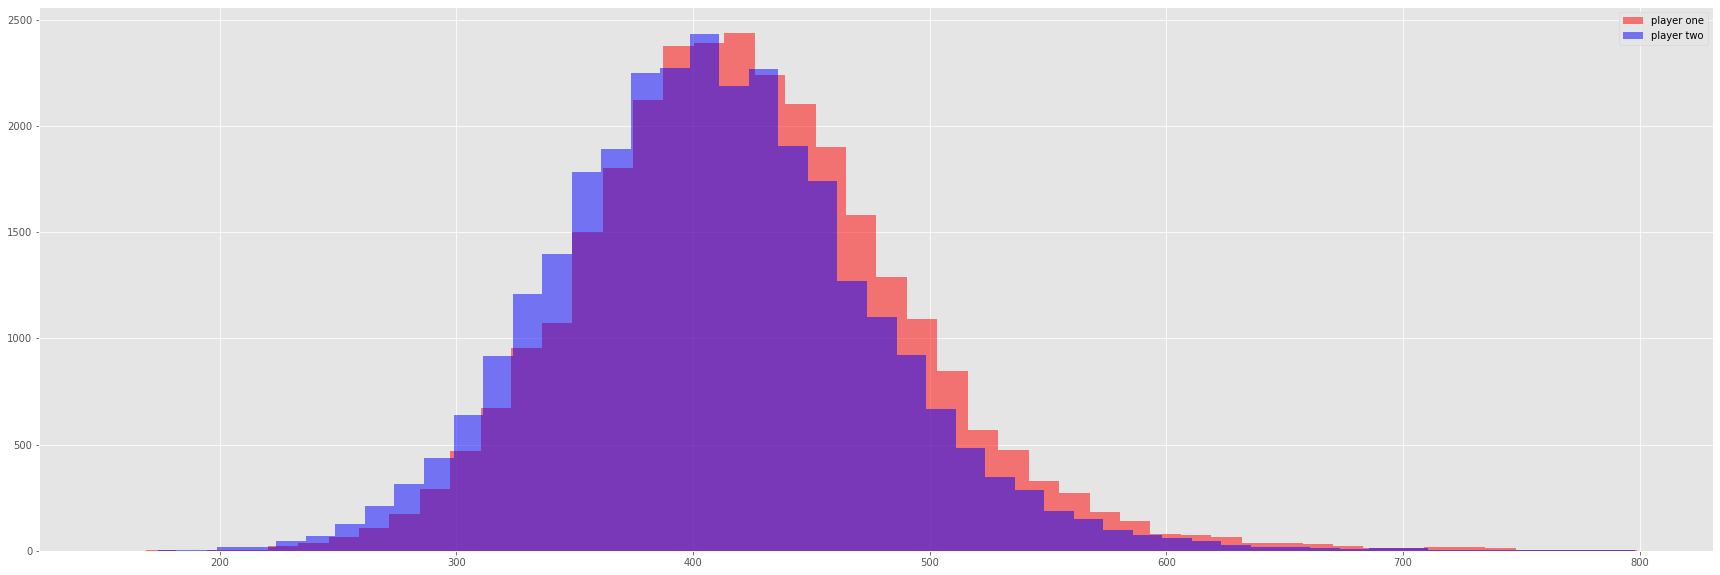

In [109]:
fig, ax = plt.subplots(figsize=(30,10))
ax.hist([p1_scores.p1_final_score], bins=50, alpha=0.5, color="red", label="player one")
ax.hist(p2_scores.p2_final_score, bins=50, alpha=0.5, color="blue", label="player two")
ax.legend()

(array([2.0600e+02, 3.7140e+03, 1.3028e+04, 1.0426e+04, 2.2360e+03,
        2.9500e+02, 6.2000e+01, 1.6000e+01, 8.0000e+00, 2.0000e+00]),
 array([174., 255., 336., 417., 498., 579., 660., 741., 822., 903., 984.]),
 <a list of 10 Patch objects>)

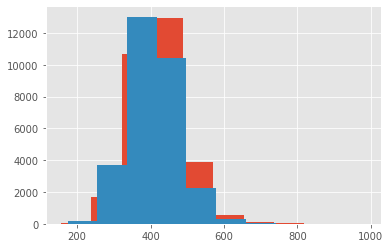

In [8]:
np.mean(p1_scores[p1_scores.letters_cleaned.apply(lambda x: "J" in x)]["p1_final_score"])

425.07684676939357

In [17]:
p1_scores["letter_count"] = p1_scores.letters_cleaned.apply(len)
p2_scores["letter_count"] = p2_scores.letters_cleaned.apply(len)

In [16]:
np.mean(p1_scores[p1_scores.letters_cleaned.apply(lambda x: "UUUU" in x)]["letter_count"])

51.52386934673367

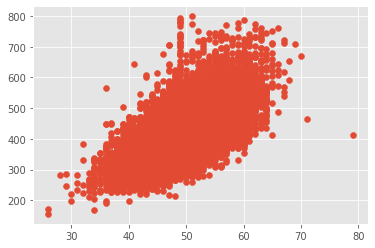

In [20]:
fig, ax = plt.subplots()
ax.scatter(p1_scores.letter_count, p1_scores.p1_final_score)

(array([2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 8.000e+00, 0.000e+00, 2.400e+01, 2.000e+01, 0.000e+00,
        5.000e+01, 0.000e+00, 8.900e+01, 0.000e+00, 1.380e+02, 0.000e+00,
        2.360e+02, 0.000e+00, 3.140e+02, 0.000e+00, 4.370e+02, 0.000e+00,
        6.570e+02, 0.000e+00, 9.240e+02, 1.179e+03, 0.000e+00, 1.499e+03,
        0.000e+00, 1.813e+03, 0.000e+00, 2.177e+03, 0.000e+00, 2.308e+03,
        0.000e+00, 2.580e+03, 0.000e+00, 2.626e+03, 0.000e+00, 2.439e+03,
        0.000e+00, 2.279e+03, 2.059e+03, 0.000e+00, 1.687e+03, 0.000e+00,
        1.278e+03, 0.000e+00, 9.820e+02, 0.000e+00, 7.120e+02, 0.000e+00,
        4.900e+02, 0.000e+00, 3.690e+02, 0.000e+00, 2.390e+02, 0.000e+00,
        1.420e+02, 8.400e+01, 0.000e+00, 5.000e+01, 0.000e+00, 4.100e+01,
        0.000e+00, 1.400e+01, 0.000e+00, 6.000e+00, 0.000e+00, 6.000e+00,
        0.000e+00, 2.000e+00, 0.000e+0

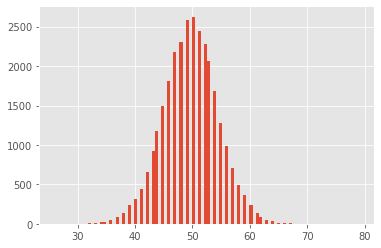

In [22]:
fig, ax = plt.subplots()
ax.hist(p1_scores.letter_count, bins=100)

In [87]:

cur = conn.cursor()

sql = """SELECT movenum, turn_score, move, rack, LAG (move, 1)  OVER (PARTITION BY gamenum ORDER BY movenum) as prev_move 
from turn where gamenum in (SELECT gamenum from fullP2games) and is_player2 = ' 1' ORDER BY movenum"""

df_95 = pd.read_sql(sql ,con=conn)

In [38]:
df_95

,movenum,move,rack,prev_move
0,2,.AWER,AABEORW,None
1,4,AE.OBIA,AABEEIO,.AWER
2,6,YEW,CEIIUWY,AE.OBIA
3,8,jURI.TIC,?CIIRTU,YEW
4,10,MITRED,DEIMRTT,jURI.TIC
5,12,QI,AEIIQTZ,MITRED
6,14,.ANITIZE,AEIINTZ,QI
7,16,.R...D,DDIIMNR,.ANITIZE
8,18,INDAMIN.,ADIIMNN,.R...D
9,20,FOP,EEFGLOP,INDAMIN.


In [83]:
all_draws = ""
leave = ""
for idx, r in df_95.iloc[0:,:].iterrows():
    draw = r["rack"]
    for l in leave:
        draw = draw.replace(l, '', 1)
    print (draw)
    print( r["rack"], r["move"].replace('.',''))
    leave = r["rack"]
    for l in r["move"]:
        leave = leave.replace(l, '',1)
    print ("leave: " + leave + "  draw: " + draw)
    all_draws += draw

AABEORW
AABEORW AWER
leave: ABO  draw: AABEORW
AEEI
AABEEIO AEOBIA
leave: E  draw: AEEI
CIIUWY
CEIIUWY YEW
leave: CIIU  draw: CIIUWY
?RT
?CIIRTU jURITIC
leave: ?  draw: ?RT
DEIMRTT
DEIMRTT MITRED
leave: T  draw: DEIMRTT
AEIIQZ
AEIIQTZ QI
leave: AEITZ  draw: AEIIQZ
IN
AEIINTZ ANITIZE
leave:   draw: IN
DDIIMNR
DDIIMNR RD
leave: DIIMN  draw: DDIIMNR
AN
ADIIMNN INDAMIN
leave:   draw: AN
EEFGLOP
EEFGLOP FOP
leave: EEGL  draw: EEFGLOP
EKO
EEEGKLO OGLE
leave: EEK  draw: EKO

EEK EEK
leave:   draw: 


'AABEORWAEEICIIUWY?RTDEIMRTTAEIIQZINDDIIMNRANEEFGLOPEKO'

In [85]:
conn.close()

In [249]:

cur = conn.cursor()

sql = """SELECT gamenum, turn_id, movenum, turn_score, move, rack, LAG (move, 1)  OVER (PARTITION BY gamenum ORDER BY movenum) as prev_move 
from turn where gamenum in (SELECT gamenum from fullP2games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 1' and length(rack) = 7 ORDER BY movenum"""


df_good_p2 = pd.read_sql(sql ,con=conn)
df_good_p2 = df_good_p2[df_good_p2.rack.apply(len) <= 7]
df_good_p2.rack = df_good_p2.rack.apply(sorted)
df_good_p2.rack

0         [D, D, E, L, O, O, V]
1         [A, A, D, E, M, N, U]
2         [?, A, E, E, O, O, U]
3         [D, E, F, S, T, U, Y]
4         [C, E, G, I, I, N, T]
                  ...          
179765    [I, I, L, R, T, U, V]
179766    [I, L, P, R, R, T, V]
179767    [I, L, P, R, R, T, V]
179768    [I, L, P, R, R, T, V]
179769    [I, L, P, R, R, T, V]
Name: rack, Length: 179770, dtype: object

0 A's: 32.937307572653054, 93217
290
1 A's: 37.150619512834325, 68683
331
2 A's: 30.668119280333688, 16063
212
3 A's: 22.240117994100295, 1695
102
4 A's: 15.254716981132075, 106
49
5 A's: 2.8, 5
14
 
0 B's: 34.47171703158107, 158576
331
1 B's: 32.54682574324652, 20619
230
2 B's: 28.544347826086955, 575
104
 
0 C's: 34.22553152966737, 154648
320
1 C's: 34.444070854518614, 24388
331
2 C's: 28.54359673024523, 734
128
 
0 D's: 33.982756832058804, 134952
320
1 D's: 35.400024357569116, 41055
331
2 D's: 30.658429434376718, 3642
185
3 D's: 23.700854700854702, 117
101
4 D's: 15.75, 4
32
 
0 E's: 30.88782140107775, 64950
320
1 E's: 37.36483754053538, 78635
331
2 E's: 34.84294976750278, 30538
284
3 E's: 26.55173084402956, 5142
203
4 E's: 18.002061855670103, 485
105
5 E's: 12.05, 20
32
 
0 F's: 34.465527272272304, 159851
331
1 F's: 32.345, 19400
194
2 F's: 32.834296724470136, 519
221
 
0 G's: 34.6969047668102, 145611
331
1 G's: 32.632805450981614, 32141
212
2 G's: 26.215113350125943, 1985
149
3 G'

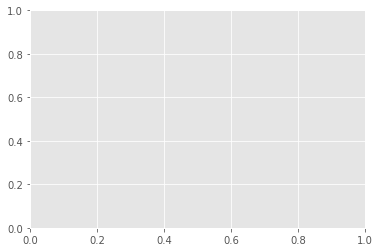

In [256]:
fig, ax = plt.subplots()
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','?']
for l in letters:
    for i in range(0, 7):
        tdf = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)==i)]
        if (tdf.shape[0]):
            print("{:} {:}'s: {:}, {:}".format(i, l, np.mean(tdf["turn_score"]), tdf.shape[0]))
            print(np.max(tdf.turn_score))
#            print(tdf["gamenum"], print(tdf["rack"]))
#        ax.hist(tdf["turn_score"], bins=100)
        
    print(" ")


In [159]:
df_good_p2.rack[1].count

TypeError: count() takes exactly one argument (2 given)

In [122]:
df_good_p2[df_good_p2.rack.apply(lambda x: x.count('E')==7)]

,movenum,turn_score,move,rack,prev_move


In [257]:
sql = """SELECT movenum, turn_score from turn where gamenum not in (SELECT * from bad_games) and NOT is_challenge"""


df_turn_compare = pd.read_sql(sql ,con=conn)

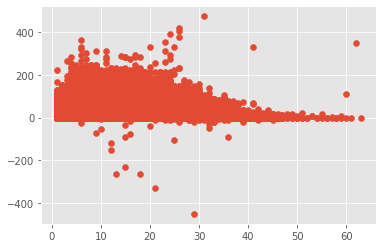

In [258]:
fig, ax = plt.subplots()
ax.scatter(df_turn_compare.movenum, df_turn_compare.turn_score)